# Random Features

## Inputs loading

In [48]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import datetime as datetime

#### Read from the database

In [24]:
conn = sqlite3.connect('db2023.db')
query = "SELECT * FROM Z_R_matrices"
results = pd.read_sql_query(query, conn)

# Columns to use for ratios
cols_ratios = ['CAPEI', 'bm', 'evm', 'pe_op_basic', 'pe_op_dil', 'pe_exi', 'pe_inc', 'ps', 'pcf',
               'dpr', 'npm', 'opmbd', 'opmad', 'gpm', 'ptpm', 'cfm', 'roa', 'roe', 'roce', 'efftax',
               'aftret_eq', 'aftret_invcapx', 'aftret_equity', 'pretret_noa', 'pretret_earnat', 'GProf',
               'equity_invcap', 'debt_invcap', 'totdebt_invcap', 'capital_ratio', 'int_debt', 'int_totdebt',
               'cash_lt', 'invt_act', 'rect_act', 'debt_at', 'debt_ebitda', 'short_debt', 'curr_debt',
               'lt_debt', 'profit_lct', 'ocf_lct', 'cash_debt', 'fcf_ocf', 'lt_ppent', 'dltt_be',
               'debt_assets', 'debt_capital', 'de_ratio', 'intcov', 'intcov_ratio', 'cash_ratio',
               'quick_ratio', 'curr_ratio', 'cash_conversion', 'inv_turn', 'at_turn', 'rect_turn',
               'pay_turn', 'sale_invcap', 'sale_equity', 'sale_nwc', 'rd_sale', 'adv_sale', 'staff_sale',
               'accrual', 'ptb', 'PEG_trailing', 'divyield']

# Columns for lagged returns
cols_lags = [f'ret_lag_{i}' for i in range(1, 13)]

# Fetch all distinct dates from the table
dates = pd.read_sql_query('SELECT DISTINCT date FROM Z_R_matrices', conn)
dates_list = dates['date'].tolist()
dates_list.sort()

#### Read from the CSV file

In [49]:
# Read the CSV file into a DataFrame
results = pd.read_csv("Z_R_matrices.csv")
# Columns to use for ratios
cols_ratios = ['CAPEI', 'bm', 'evm', 'pe_op_basic', 'pe_op_dil', 'pe_exi', 'pe_inc', 'ps', 'pcf',
               'dpr', 'npm', 'opmbd', 'opmad', 'gpm', 'ptpm', 'cfm', 'roa', 'roe', 'roce', 'efftax',
               'aftret_eq', 'aftret_invcapx', 'aftret_equity', 'pretret_noa', 'pretret_earnat', 'GProf',
               'equity_invcap', 'debt_invcap', 'totdebt_invcap', 'capital_ratio', 'int_debt', 'int_totdebt',
               'cash_lt', 'invt_act', 'rect_act', 'debt_at', 'debt_ebitda', 'short_debt', 'curr_debt',
               'lt_debt', 'profit_lct', 'ocf_lct', 'cash_debt', 'fcf_ocf', 'lt_ppent', 'dltt_be',
               'debt_assets', 'debt_capital', 'de_ratio', 'intcov', 'intcov_ratio', 'cash_ratio',
               'quick_ratio', 'curr_ratio', 'cash_conversion', 'inv_turn', 'at_turn', 'rect_turn',
               'pay_turn', 'sale_invcap', 'sale_equity', 'sale_nwc', 'rd_sale', 'adv_sale', 'staff_sale',
               'accrual', 'ptb', 'PEG_trailing', 'divyield']

# Columns for lagged returns
cols_lags = [f'ret_lag_{i}' for i in range(1, 13)]

# Convert the 'date' column to datetime
results['date'] = pd.to_datetime(results['date'])

# Extract distinct dates from the DataFrame
dates_list = results['date'].drop_duplicates().sort_values().tolist()


## Functions

In [50]:
def random_weights(d,L,weight_type = "unif_B^d", seed = 0):
    """
    Generate a matrix of random weights according to a specified distribution.

    Parameters:
    -----------
    d : int
        The dimensionality of each weight vector (number of rows in the output matrix).
    
    L : int
        The number of weight vectors to generate (number of columns in the output matrix).
    
    weight_type : str, optional, default="unif_B^d"
        The type of random weights to generate. Options include:
        - "gaussian": Standard normal distribution.
        - "unif_S^d-1": Uniformly distributed on the (d-1)-dimensional sphere S^(d-1).
        - "unif_B^d": Uniformly distributed inside the unit ball B^d_1.
    
    seed : int, optional, default=0
        The seed for the random number generator, ensuring reproducibility.

    Returns:
    --------
    W : numpy.ndarray
        A (d x L) matrix of random weights generated according to the specified distribution.

    Raises:
    -------
    ValueError
        If an invalid `weight_type` is provided.

    Notes:
    ------
    - If `weight_type` is "unif_S^d-1", the vectors are uniformly distributed over the surface
      of the unit sphere S^(d-1), meaning they have a unit norm.
    - If `weight_type` is "unif_B^d", the vectors are uniformly distributed inside the unit ball
      B^d_1, which includes scaling by a random radial distance.
    """

    # set the seed
    np.random.seed(seed)

    # sample normal
    W = np.random.normal(size = (d,L))
    
    if weight_type == "gaussian":
        return W
    elif weight_type == "unif_S^d-1":
        W = (1/np.linalg.norm(W, axis = 0, ord = 2, keepdims = True)) * W
        # Sample uniform over the Sphere S^{d-1}, i.e. we sample a random direction.
        return W
    elif weight_type == "unif_B^d":
        # Sample uniform over the ball of radius one B^d_1.
        W = (1/np.linalg.norm(W, axis = 0, ord = 2, keepdims = True)) * W
        U = np.random.uniform(low = 0, high = 1, size = L)
        Rad = U ** (1/d)  
        W = Rad * W
        return W
    else:
        raise ValueError("Invalid weight type.")

In [89]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

# Function to compute the instruments and associated factors
def compute_X_R_F(date,W, activation = "ReLU", normalize = False, winsorize = False):
    """
    Compute the instruments (X) and associated factors (F) based on the provided activation function
    and whether normalization is applied. The function takes in a specific date, a weight matrix (W),
    and the activation function to use.

    Parameters:
    -----------
    date : str or pd.Timestamp
        The date for which the instruments and factors should be computed.
        
    W : np.ndarray
        The weight matrix used in the linear transformation before applying the activation function.

    activation : str, optional (default="ReLU")
        The activation function to apply. Options are:
        - "ReLU": Applies the Rectified Linear Unit function (ReLU).
        - "tanh": Applies the hyperbolic tangent function (tanh).
        - "sigmoid": Applies the sigmoid function.
        An error is raised if an invalid activation function is provided.

    normalize : bool, optional (default=False)
        If True, the computed instruments (X) will be centered and normalized:
        - Centered: Mean-centered so that the average of each characteristic is zero.
        - Normalized: Scaled to have a unit one norm, meaning each column has a leverage of one dollar.

    winsorize : bool, optional (default=False)
        If True, the returns will be winsorized at 100% to remove the influence of outliers.
    
    Returns:
    --------
    X : np.ndarray
        The computed instruments after applying the activation function and (optionally) normalization.

    R : np.ndarray
        The vector of adjusted returns (`R_e_adj`) for the specified date.

    F : np.ndarray
        The computed factors associated with the random features, obtained by multiplying 
        the transpose of X with R.

    Raises:
    -------
    ValueError:
        If an invalid activation function is specified.

    Notes:
    ------
    The function assumes that `results` is a pre-existing DataFrame with relevant data, 
    and that `cols_ratios` and `cols_lags` are predefined lists of column names. The 
    adjusted returns (`R_e_adj`) are expected to be a column in the DataFrame `results`.

    Example:
    --------
    X, R, F = compute_X_R_F("2023-01-31", W, activation="tanh", normalize=False)
    """
    Z_R = results[results["date"] == date]
    Z = Z_R[cols_ratios+cols_lags].to_numpy()
    R = Z_R["R_e_adj"].to_numpy()
    if activation == "ReLU":
        X = np.maximum(Z@W,0) 
    elif activation == "tanh":
        X = np.tanh(Z@W)
    elif activation == "sigmoid":
        X = sigmoid(Z@W)
    else:
        raise ValueError("Invalid activation.")
    #N_t = R.shape[0]
    #X = (1/N_t) * X
    if normalize:
        # center the derived characteristics
        X = X - np.mean(X, axis = 0, keepdims = True)
        # normalize so they have unit one norm (i.e. fixed leverage, one dollar exposure).
        X = (1/np.linalg.norm(X, axis = 0, ord = 1, keepdims = True)) * X 
        # X = (1/np.std(X, axis = 0, keepdims = True)) * X # alternative normalization
    
    if winsorize:
        R = np.minimum(R,1.0)
    # compute the factors associated with the random features
    F =  X.T @ R
    return X, R, F

In [52]:
# Plotting functions

def plot_SR(gammas,SR):
    # Plot the out-of-sample Sharpe ratios
    plt.plot(gammas, SR)
    plt.xscale('log')
    plt.xlabel('$\gamma$')
    plt.ylabel('OOS SR')
    plt.title('OOS Sharpe ratio ($\gamma$)')
    plt.show()

def plot_yoy_return_over_time(return_series):
    """
    Computes and plots the YoY return over time for a given series of monthly returns using log returns.
    
    Parameters:
    - return_series: pd.Series, monthly returns indexed by datetime.
    
    Returns:
    - yearly_compounded_returns: pd.Series, the YoY compounded returns.
    """
    # Ensure the index is in datetime format
    return_series.index = pd.to_datetime(return_series.index)

    # Calculate log returns
    log_returns = np.log(1 + return_series)

    # Calculate the rolling 12-month sum of log returns
    rolling_log_returns = log_returns.rolling(window=12).sum()

    # Convert back to regular returns
    yearly_compounded_returns = np.exp(rolling_log_returns) - 1

    # Convert to percentage
    yearly_compounded_returns = yearly_compounded_returns * 100
    yearly_compounded_returns =yearly_compounded_returns.dropna()

    # Plot the yearly compounded return over time
    plt.figure(figsize=(12, 6))
    plt.plot(yearly_compounded_returns)
    plt.xlabel('Date')
    plt.ylabel('YoY Return (%)')
    plt.title('YoY Return Over Time')

    # Set x-axis major ticks to show each year
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Set minor ticks to show every month
    plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())
    plt.gcf().autofmt_xdate()
    plt.xlim([yearly_compounded_returns.index[0], yearly_compounded_returns.index[-1]])

    plt.grid(True)
    plt.show()

    return yearly_compounded_returns


def plot_cumulative_return(return_series):
    """
    Computes and plots the cumulative return over time for a given series of monthly returns.
    
    Parameters:
    - return_series: pd.Series, monthly returns indexed by datetime.
    
    Returns:
    - cumulative_returns: pd.Series, the cumulative returns.
    """
    # Ensure the index is in datetime format
    return_series.index = pd.to_datetime(return_series.index)
    
    # Calculate the cumulative return over time
    cumulative_returns = (1 + return_series).cumprod()

    # Convert to percentage if needed
    cumulative_returns = cumulative_returns * 100

    # Plot the cumulative return over time
    plt.figure(figsize=(12, 6))
    plt.plot(cumulative_returns.index, cumulative_returns)
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return (%)')
    plt.title('Cumulative Return Over Time')

    # Set x-axis major ticks to show each year
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Set minor ticks to show every month
    plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())
    plt.gcf().autofmt_xdate()
    plt.xlim([cumulative_returns.index[0], cumulative_returns.index[-1]])

    # Set y-axis to log scale and format the ticks as plain numbers
    plt.yscale('log')
    plt.gca().yaxis.set_major_formatter(mticker.ScalarFormatter())
    plt.gca().yaxis.set_minor_formatter(mticker.ScalarFormatter())
    plt.gca().ticklabel_format(style='plain', axis='y')

    plt.grid(True)
    plt.show()

    return cumulative_returns

## Random weights and factors computation

In [93]:
# Computing Random Weights

d = len(cols_ratios+cols_lags) # number of basic characteristics.
T = len(dates_list)            # Length of our dataset.
L = 128 * d                    # Number of random weights (thus factors).

weight_type = "unif_B^d"                    # weight type
seed = 0                                    # set seed here, only random part of the algorithm are the weights.
W = random_weights(d,L, weight_type,seed)   # compute random weights

In [94]:
# Compute Factors

activation = "ReLU" # type of activation units to be used to define the factors.
normalize = False   # set to true if instruments are to be centered and normalised to have unit 1-norm (on a monthly basis)
winsorize = True
F = np.zeros((L,T)) # F is the matrix of factors.
for (t,date) in enumerate(dates_list):
    _, _, F_t = compute_X_R_F(date,W,activation,normalize, winsorize)
    F[:,t] = F_t

## Market returns

In [95]:
# Define the in-sample (IS) size and rolling window size for the analysis
IS_size = 360  # Number of months for the in-sample in our simple split analysis.
               # For example, 419 for the period Jan-2005 to Dec-2023

rolling_window_size = 360  # Rolling window size of 30 years for rolling window analysis

# Query the Fama-French dataset from the connected database
query_ff = "SELECT * FROM Fama_French"
fama_french = pd.read_sql_query(query_ff, conn)

# Convert the market excess return ("mktrf") column to numeric values, coercing errors to NaN
mkt = pd.to_numeric(fama_french["mktrf"], errors='coerce')

# Calculate the Sharpe Ratio for the market from Jan-2005 to Dec-2023
SR_mkt_split = np.mean(mkt[IS_size+1:]) / np.std(mkt[IS_size+1:]) * np.sqrt(12)
print("Sharpe Ratio Market Simple Split:", SR_mkt_split)

# Calculate the Sharpe Ratio for the market over the entire period (from the rolling window size onwards)
SR_mkt_roll = np.mean(mkt[rolling_window_size+1:]) / np.std(mkt[rolling_window_size+1:]) * np.sqrt(12)
print("Sharpe Ratio Market Rolling (Feb-2000 to Dec-2023):", SR_mkt_roll)

# Convert the "dateff" column to datetime format for proper date handling
fama_french["date"] = pd.to_datetime(fama_french["dateff"])

# Convert the risk-free rate ("rf") column to numeric values, coercing errors to NaN
risk_free = pd.to_numeric(fama_french["rf"], errors='coerce')

# Set the index of the risk-free rate series to the corresponding dates for easier time series manipulation
risk_free.index = fama_french["date"]

Sharpe Ratio Market Simple Split: 0.4271197852705348
Sharpe Ratio Market Rolling (Feb-2000 to Dec-2023): 0.4271197852705348


## Simple Split

In [96]:
# Split between training (IS) and test set (OOS)
F_IS = F[:,:IS_size]
T_IS = F_IS.shape[1]
F_OOS = F[:,IS_size:]
T_OOS = F_OOS.shape[1]
# Regularization parameters
n_gamma = 30
gammas = np.logspace(-10,3,num = n_gamma, base = 10)

# Compute optimal portfolio coefficients
b_hat_split = np.zeros((n_gamma,L))
for (i,gamma) in enumerate(gammas):
    b_hat_split[i,:] = (1/T_IS) * F_IS @ np.linalg.solve((1/T_IS) * F_IS.T @ F_IS + gamma * np.eye(T_IS), np.ones(T_IS))

# OOS Sharpe ratios

# compute portfolio excess returns out of sample
R_P_OOS_split = b_hat_split @ F_OOS
SR_OOS_split = np.mean(R_P_OOS_split,axis = 1)/np.std(R_P_OOS_split,axis = 1) * np.sqrt(12)

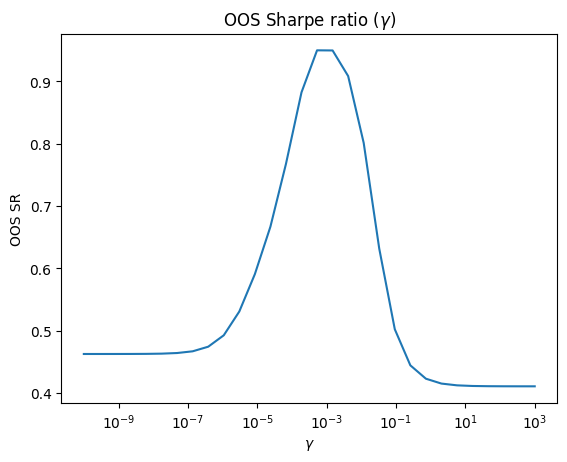

In [97]:
plot_SR(gammas,SR_OOS_split)

In [103]:
# Construct a portfolio with unit leverage (i.e. ||w_t||_1 = 1 for all times)
R_P_OOS_split_lev = np.zeros((n_gamma,T_OOS))
for (t,date) in enumerate(dates_list[IS_size:]):
    X_t, R, _ = compute_X_R_F(date,W,activation,normalize)
    v_t = X_t @ b_hat_split.T
    w_t = v_t/np.linalg.norm(v_t, axis = 0, ord = 1)
    R_P_OOS_split_lev[:,t] = w_t.T @ R

In [104]:
# Choose the portfolio return with maximum Sharpe ratio
SR_OOS_split_lev = np.mean(R_P_OOS_split,axis = 1)/np.std(R_P_OOS_split,axis = 1) * np.sqrt(12)
R_P_split_max = R_P_OOS_split_lev[np.argmax(SR_OOS_split_lev),:]

In [105]:
# Compute return (excess + risk free) and save it in a Series
index_split_oos = pd.to_datetime(dates_list[IS_size + 1:]+ ["2023-12-29"])
R_P_split_max_tot = pd.Series(R_P_split_max, index = index_split_oos) + risk_free[index_split_oos]
# notice that there is a one month shift as recall that Z_R has (Z_t,R_t+1)

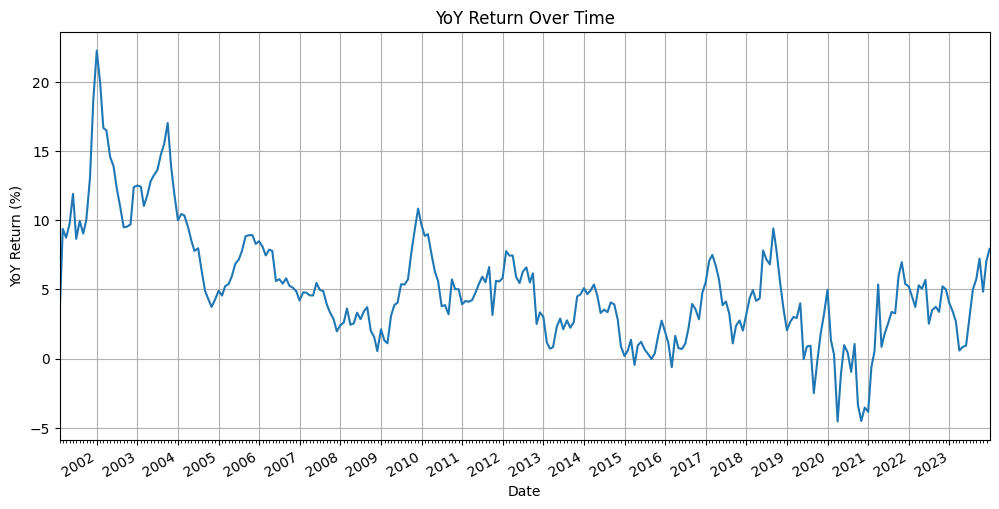

In [106]:
split_yoy_ret = plot_yoy_return_over_time(R_P_split_max_tot)

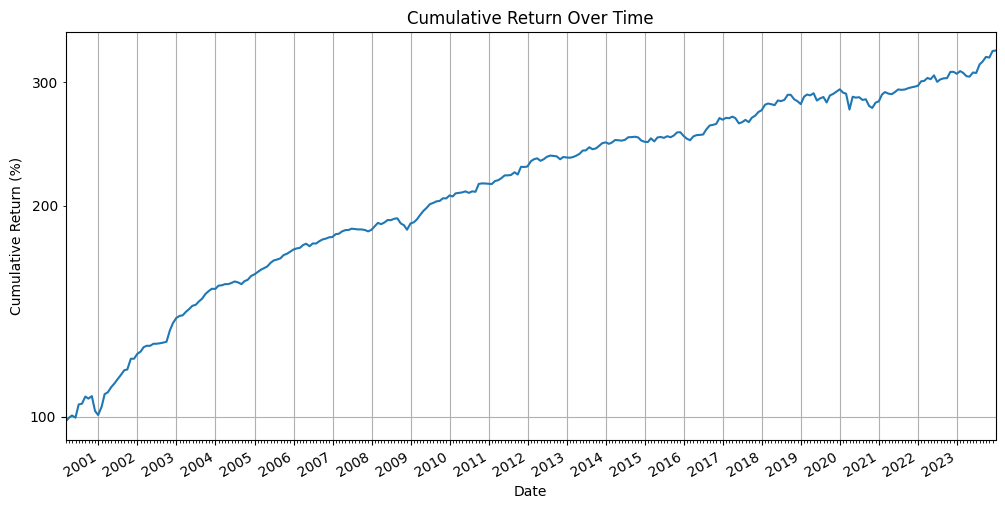

In [107]:
split_cumulative_ret = plot_cumulative_return(R_P_split_max_tot)

## Rolling Window

In [43]:
# Define the rolling window size
rolling_window_size = 360

# Regularization parameters
n_gamma = 30
gammas = np.logspace(-10, 3, num=n_gamma, base=10)

# Initialize array to store out-of-sample portfolio returns
R_P_OOS_rolling = np.zeros((n_gamma, T - rolling_window_size))
R_P_OOS_rolling_lev = np.zeros((n_gamma, T - rolling_window_size))

t = rolling_window_size
for t, date in enumerate(dates_list[rolling_window_size:], start=rolling_window_size):
    F_IS = F[:, t - rolling_window_size:t]
    F_OOS = F[:, t]

    # Compute optimal portfolio coefficients
    b_hat_rolling = np.zeros((n_gamma, L))
    for (i, gamma) in enumerate(gammas):
        b_hat_rolling[i, :] = (1 / rolling_window_size) * F_IS @ np.linalg.solve((1 / rolling_window_size) * F_IS.T @ F_IS + gamma * np.eye(rolling_window_size), np.ones(rolling_window_size))
    
    # Compute portfolio excess returns out of sample
    R_P_OOS_day = b_hat_rolling @ F_OOS
    R_P_OOS_rolling[:, t - rolling_window_size] = R_P_OOS_day
    
    # unit leverage returns
    X_t, R, _ = compute_X_R_F(date,W,activation,normalize)
    v_t = X_t @ b_hat_rolling.T
    w_t = v_t/np.linalg.norm(v_t, axis = 0, ord = 1)
    R_P_OOS_rolling_lev[:,t-rolling_window_size] = w_t.T @ R

# Compute OOS Sharpe ratios
SR_OOS_rolling = np.mean(R_P_OOS_rolling, axis=1) / np.std(R_P_OOS_rolling, axis=1) * np.sqrt(12)

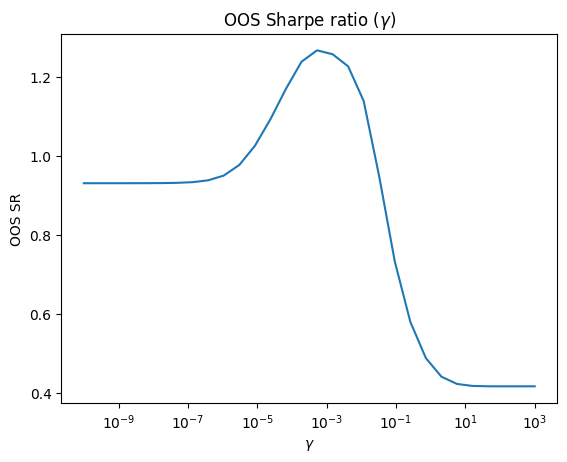

In [44]:
plot_SR(gammas, SR_OOS_rolling)

In [66]:
SR_OOS_rolling_lev = np.mean(R_P_OOS_rolling_lev, axis=1) / np.std(R_P_OOS_rolling_lev, axis=1) * np.sqrt(12)
R_P_OOS_rolling_max = R_P_OOS_rolling_lev[np.argmax(SR_OOS_rolling_lev),:]

# Compute return (excess + risk free) and save it in a Series
index_rolling_oos = pd.to_datetime(dates_list[rolling_window_size + 1:]+ [pd.Timestamp('2023-12-29 00:00:00')])
R_P_OOS_rolling_max_tot = pd.Series(R_P_OOS_rolling_max, index = index_rolling_oos) + risk_free[index_rolling_oos]

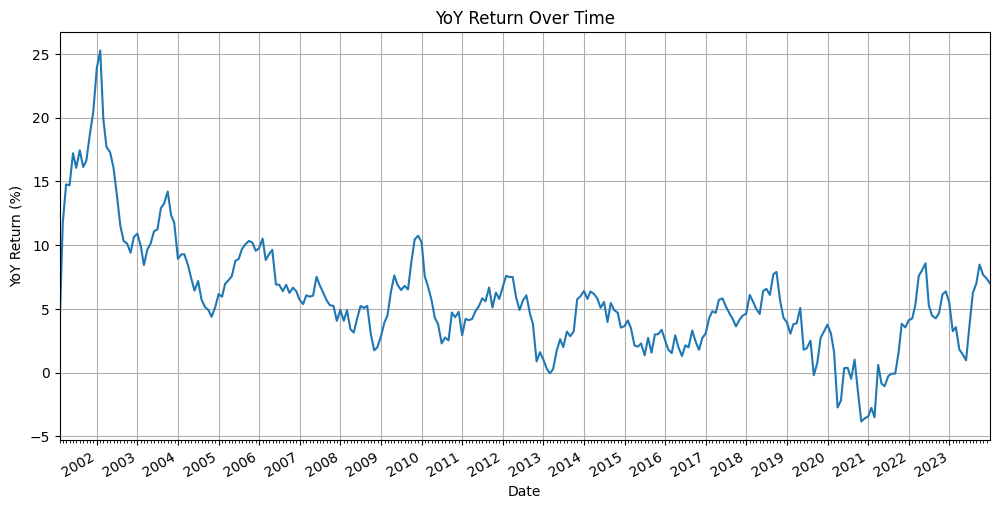

In [67]:
rolling_yoy_ret = plot_yoy_return_over_time(R_P_OOS_rolling_max_tot)

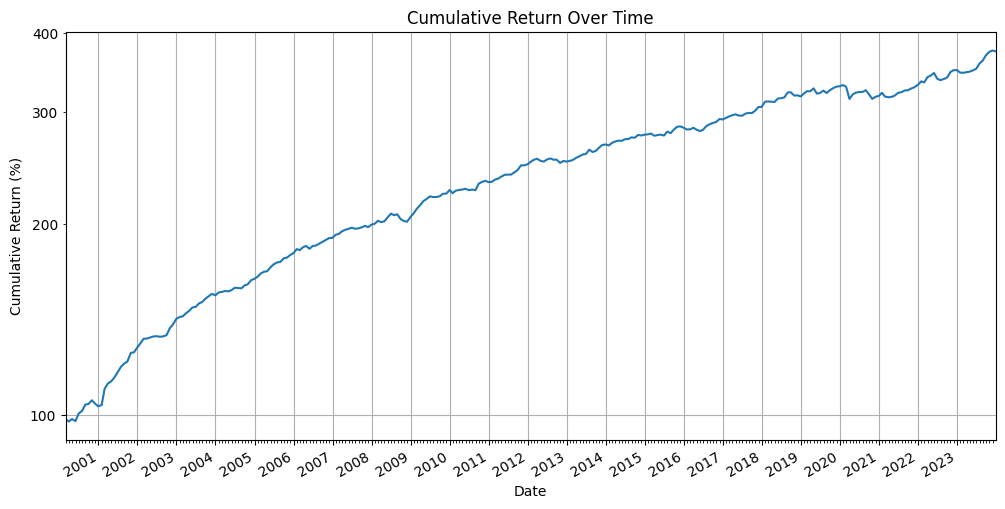

2000-02-29     98.458475
2000-03-31     97.665087
2000-04-28     98.504795
2000-05-31     97.778673
2000-06-30    100.539248
                 ...    
2023-08-31    362.351925
2023-09-29    369.219720
2023-10-31    373.852077
2023-11-30    375.614760
2023-12-29    374.471679
Length: 287, dtype: float64

In [68]:
rolling_cumulative_ret = plot_cumulative_return(R_P_OOS_rolling_max_tot)
rolling_cumulative_ret

## Different number of factors

In [74]:
# Define the rolling window size
rolling_window_size = 360

# Regularization parameters
n_gamma = 30
gammas = np.logspace(-10, 3, num=n_gamma, base=10)

# Multipliers for the number of factors
multipliers = [0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64, 128]

# Initialize array to store out-of-sample portfolio returns for each combination
R_P_OOS_all = np.zeros((len(multipliers), n_gamma, T - rolling_window_size))

for m_idx, multiplier in enumerate(multipliers):
    L_m = int(multiplier * d)
    for t in range(rolling_window_size, T):
        F_IS = F[:L_m, t - rolling_window_size:t]
        F_OOS = F[:L_m, t]

        b_hat = np.zeros((n_gamma, L_m))
        for i, gamma in enumerate(gammas):
            b_hat[i, :] = (1 / rolling_window_size) * F_IS @ np.linalg.solve((1 / rolling_window_size) * F_IS.T @ F_IS + gamma * np.eye(rolling_window_size), np.ones(rolling_window_size))

        # Compute portfolio excess returns out of sample
        R_P_OOS_day = b_hat @ F_OOS
        R_P_OOS_all[m_idx, :, t - rolling_window_size] = R_P_OOS_day
    print("Finished processing multiplier:", multiplier)

# Compute OOS Sharpe ratios for each combination of factors and gammas
SR_OOS_all = np.zeros((len(multipliers), n_gamma))
for m_idx in range(len(multipliers)):
    for g_idx in range(n_gamma):
        R_P_OOS_mg = R_P_OOS_all[m_idx, g_idx, :]
        SR_OOS_all[m_idx, g_idx] = np.mean(R_P_OOS_mg) / np.std(R_P_OOS_mg) * np.sqrt(12)


Finished processing multiplier: 0.125
Finished processing multiplier: 0.25
Finished processing multiplier: 0.5
Finished processing multiplier: 1
Finished processing multiplier: 2
Finished processing multiplier: 4
Finished processing multiplier: 8
Finished processing multiplier: 16
Finished processing multiplier: 32
Finished processing multiplier: 64
Finished processing multiplier: 128


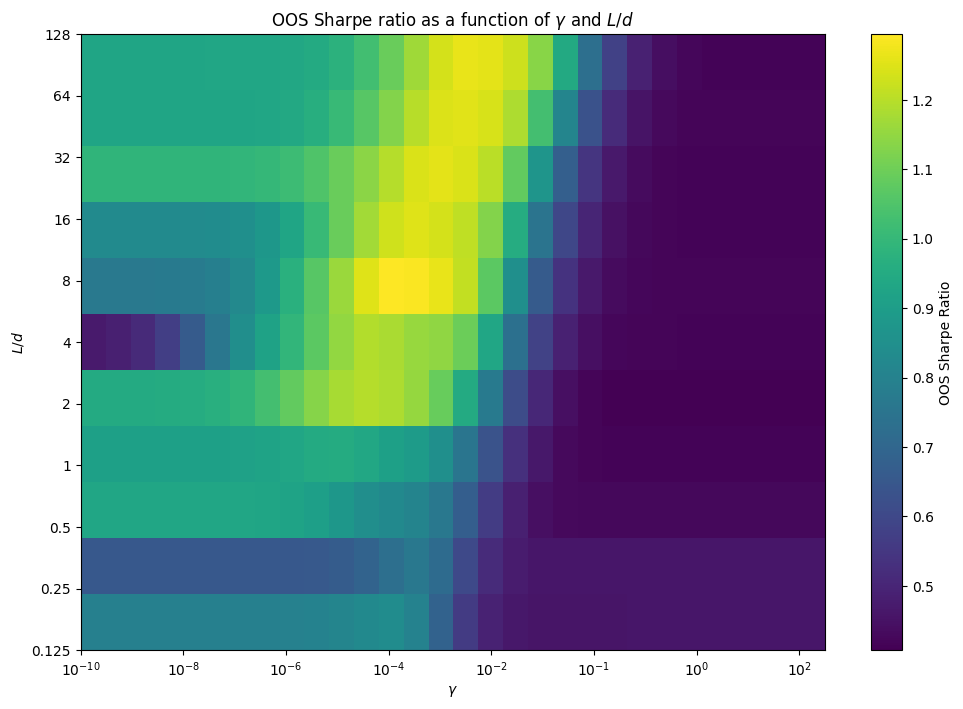

In [83]:
# Plot the out-of-sample Sharpe ratios as a color map
plt.figure(figsize=(12, 8))

# Plot with gamma on x-axis and L/d on y-axis, both in log scale
plt.imshow(SR_OOS_all, aspect='auto', cmap='viridis',
           extent=[np.log10(gammas[0]), np.log10(gammas[-1]), np.log10(multipliers[-1]), np.log10(multipliers[0])])

# Add colorbar
plt.colorbar(label='OOS Sharpe Ratio')

# Set x-axis to show log-scale of gamma
plt.xlabel('$\gamma$')

# Set y-axis label
plt.ylabel('$L/d$')

# Set plot title
plt.title('OOS Sharpe ratio as a function of $\gamma$ and $L/d$')

# Invert y-axis to have multipliers in the correct order
plt.gca().invert_yaxis()

# Set custom y-ticks to show the original multiplier values
yticks = np.log10(multipliers)
ytick_labels = [f'{m}' for m in multipliers]
plt.yticks(ticks=yticks, labels=ytick_labels)

# Reduce the number of x-ticks by selecting a subset of gamma values
xticks = np.log10(gammas)[::4]  # Select every second gamma value for fewer ticks
xtick_labels = [f'$10^{{{int(np.log10(g))}}}$' for g in gammas[::4]]  # Corresponding labels
plt.xticks(ticks=xticks, labels=xtick_labels)

# Display the plot
plt.show()

In [194]:
np.max(SR_OOS_all)

1.294597952910637

## Cross Validation Rolling Window

In [69]:
# Define the rolling window size
rolling_window_size = 360

# Regularization parameters
n_gamma = 30
gammas = np.logspace(-10, 3, num=n_gamma, base=10)

# Initialize array to store out-of-sample portfolio returns
R_P_OOS_cv = np.zeros(T - rolling_window_size)
R_P_OOS_cv_lev = np.zeros(T - rolling_window_size)
optimal_gammas = np.zeros(T - rolling_window_size)

# Number of folds for cross-validation
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle = False)

for t, date in enumerate(dates_list[rolling_window_size:], start=rolling_window_size):
    F_IS = F[:, t - rolling_window_size:t]
    F_OOS = F[:, t]

    # every year we perform a cross validation to find the optimal gamma.
    if ((t-rolling_window_size) % 12 == 0):
        # Initialize variables to track the best gamma and its corresponding objective
        best_gamma = None
        best_cv_obj = np.inf

        # Cross-validation to find the best gamma
        for gamma in gammas:
            cv_obj = []

            for train_index, val_index in kf.split(F_IS.T):
                F_train, F_val = F_IS[:, train_index], F_IS[:, val_index]
                T_train = F_train.shape[1]

                # Solve for b_hat using training data
                b_hat_cv = (1 / T_train) * F_train @ np.linalg.solve((1 / T_train) * F_train.T @ F_train + gamma * np.eye(T_train), np.ones(T_train))

                # Compute the CV objective on validation data
                ones_val = np.ones(F_val.shape[1])
                prediction = b_hat_cv.T @ F_val
                objective = np.mean((ones_val - prediction) ** 2)

                cv_obj.append(objective)

            # Average R² across all folds
            avg_cv_obj = np.mean(cv_obj)

            # Update the best gamma if the current one is better
            if avg_cv_obj < best_cv_obj:
                best_cv_obj = avg_cv_obj
                best_gamma = gamma

    # Store the best gamma for this window
    optimal_gammas[t - rolling_window_size] = best_gamma

    # Use the best gamma to compute b_hat and OOS returns
    b_hat_optimal = (1 / rolling_window_size) * F_IS @ np.linalg.solve((1 / rolling_window_size) * F_IS.T @ F_IS + best_gamma * np.eye(rolling_window_size), np.ones(rolling_window_size))
    R_P_OOS_cv[t - rolling_window_size] = b_hat_optimal @ F_OOS

    # unit leverage returns
    X_t, R, _ = compute_X_R_F(date,W,activation,normalize)
    v_t = X_t @ b_hat_optimal
    w_t = v_t/np.linalg.norm(v_t, axis = 0, ord = 1)
    R_P_OOS_cv_lev[t-rolling_window_size] = w_t.T @ R

# Compute OOS Sharpe ratios
SR_OOS_cv = np.mean(R_P_OOS_cv) / np.std(R_P_OOS_cv) * np.sqrt(12)


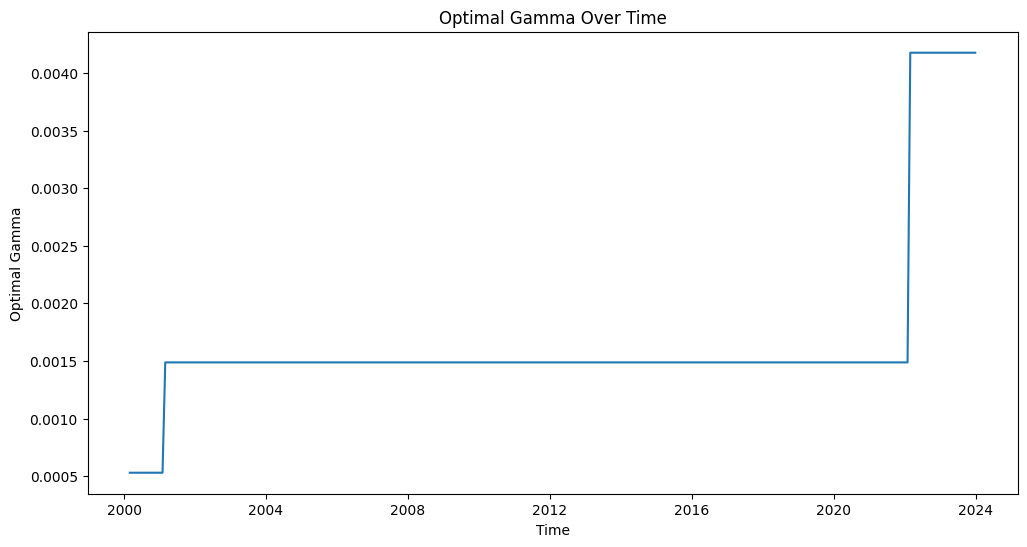

OOS Sharpe ratio:  1.2379207345398948


In [70]:

# Plot the optimal gammas over time
plt.figure(figsize=(12, 6))
plt.plot(index_rolling_oos, optimal_gammas)
plt.xlabel('Time')
plt.ylabel('Optimal Gamma')
plt.title('Optimal Gamma Over Time')
plt.show()

print("OOS Sharpe ratio: ", SR_OOS_cv)

In [71]:
# Compute return (excess + risk free) and save it in a Series
R_P_OOS_cv_tot = pd.Series(R_P_OOS_cv_lev, index = index_rolling_oos) + risk_free[index_rolling_oos]

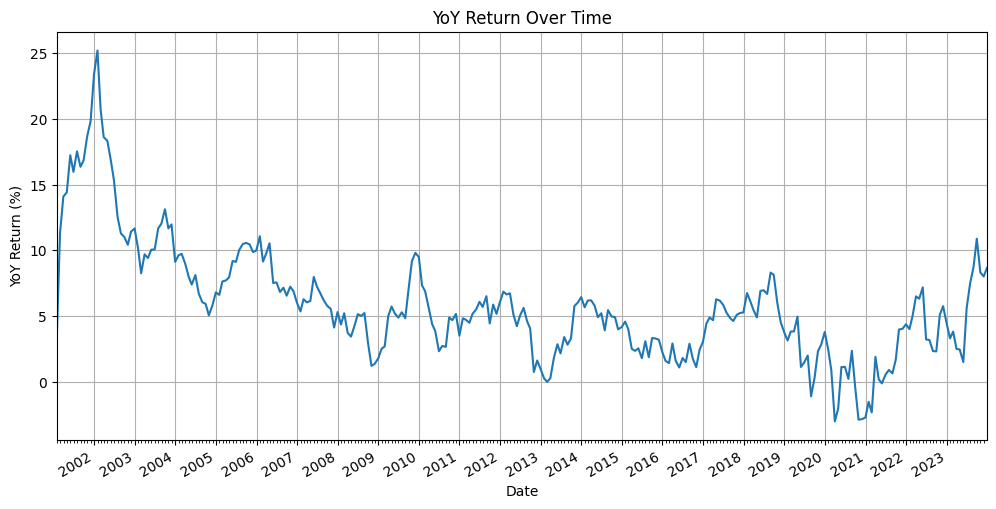

In [72]:
cv_yoy_ret = plot_yoy_return_over_time(R_P_OOS_cv_tot)

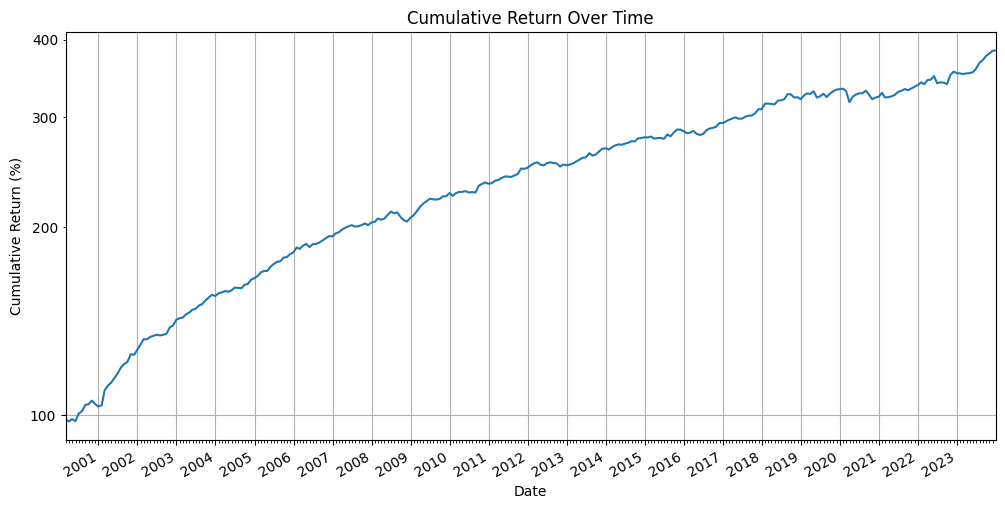

2000-02-29     98.458475
2000-03-31     97.665087
2000-04-28     98.504795
2000-05-31     97.778673
2000-06-30    100.539248
                 ...    
2023-08-31    370.822750
2023-09-29    376.332691
2023-10-31    379.859771
2023-11-30    383.741549
2023-12-29    384.115073
Length: 287, dtype: float64

In [73]:
cv_cumulative_ret = plot_cumulative_return(R_P_OOS_cv_tot)
cv_cumulative_ret